In [1]:
import becquerel as bq
from becquerel import Spectrum
from becquerel.tools import Isotope, IsotopeQuantity, NeutronIrradiation
import datetime
import numpy as np
import scipy.integrate as integrate
import math as m
import importlib
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
#sys.path.insert(0,r"C:\Users\Daniel\Desktop\Radwatch\radwatch-analysis")
sys.path.insert(0,r'C:\Users\ahanks\DoseNet\radwatch-analysis')

In [22]:
import PF
import naa_isotope_analyzer as naa
import analysis_methods as am
import ROI
importlib.reload(PF)
importlib.reload(naa)
importlib.reload(am)
importlib.reload(ROI)

<module 'ROI' from 'C:\\Users\\ahanks\\DoseNet\\radwatch-analysis\\ROI.py'>

In [19]:
def get_isotopes(energies):
    hl_cut = 3600 #in becq.fetch decay radiation
    br_cut =1.0
    df = naa.naa_isotope_analyzer(energies.tolist(),hl_cut,br_cut)
    
    return df

In [6]:
def f_near(a,a0):
    idx = np.abs(a-a0).argmin()
    return idx
        
def plot_peak_region(spectrum,source_energies,source_isotopes):
    roi.find_peak_energies()
    target_peaks = roi.target_peaks
    print(target_peaks)
    for i,j,isotope in zip(source_energies,target_peaks,source_isotopes):
        spec = spectrum
        counts = spec.counts_vals
        energies = spec.energies_kev
        idx = f_near(energies,i) 
        roi_low = idx - 50
        roi_high = idx + 50

        plot_counts = counts[roi_low:roi_high]
        plot_energies = energies[roi_low:roi_high]

        roi_low_bins,roi_peak_bins,roi_high_bins = roi.get_roi_windows(j)
        rlow = roi_low_bins[0][0]
        rhi = roi_high_bins[0][-1]
        plot_counts = counts[rlow:rhi]
        plot_energies = energies[rlow:rhi]

        rlow = roi_low_bins[0][0]
        rhi = roi_low_bins[0][-1]
        low_counts = counts[rlow:rhi]
        low_energies = energies[rlow:rhi]

        rlow = roi_high_bins[0][0]
        rhi = roi_high_bins[0][-1]
        high_counts = counts[rlow:rhi]
        high_energies = energies[rlow:rhi]

        rlow = roi_peak_bins[0][0]
        rhi = roi_peak_bins[0][-1]
        peak_counts = counts[rlow:rhi]
        peak_energies = energies[rlow:rhi]

        fig,ax = plt.subplots()
        ax.plot(plot_energies,plot_counts)
        ax.fill_between(low_energies,0,low_counts,facecolor = 'green',interpolate=True)
        ax.fill_between(high_energies,0,high_counts,facecolor = 'red',interpolate=True)
        ax.fill_between(peak_energies,0,peak_counts,facecolor = 'blue',interpolate=True)
        ax.set_yscale('log')
        plt.title(isotope)
        #plt.savefig('isotope %s.png'%isotope,dpi = 200)

In [60]:
def plot_spec(spectrum, xmode='channel'):
    if xmode == 'channel':
        facecolor = 'green'
    else:
        facecolor = 'blue'
    plt.figure()
    spectrum.fill_between(xmode=xmode, facecolor=facecolor, alpha=0.4, ax=plt.gca())
    spectrum.plot('k-', lw=0.7, xmode=xmode, ax=plt.gca())
    if xmode == 'channel':
        plt.xlim(0, spectrum.bin_edges_raw.max())
        plt.title('Uncalibrated spectrum')
    else:
        plt.xlim(0, spectrum.energies_kev[-1])
        plt.title('Calibrated spectrum')
    plt.yscale('log')
    plt.ylim(2e-1)
    plt.tight_layout()


In [11]:
#use the ecal and bgspec from google drive
#implement choosing between relevant ecal and bg for diff sample groups
path = r"C:\Users\ahanks\Google Drive\RadWatch\Gamma\Gamma Spectra\Fish Samples 2019"
e_cal = np.loadtxt(path + r"\NAA\11-19-2019-Calibration.Ent")
bgspec =  Spectrum.from_file(path + r"\NAA\Background_Spectrum_12_20_19.Spe")
#detector ϵ placeholder = .001

SpeFile: Reading file C:\Users\ahanks\Google Drive\RadWatch\Gamma\Gamma Spectra\Fish Samples 2019\\NAA\Background_Spectrum_12_20_19.Spe


In [12]:
#specs for testing
spec_30 = Spectrum.from_file(path+r"\NAA\ucb1901-30min.Spe")
spec_03 = Spectrum.from_file(path+r"\NAA\ucb1901-3hr.Spe")
spec_24 = Spectrum.from_file(path+r"\NAA\ucb1901-24hr.Spe")

SpeFile: Reading file C:\Users\ahanks\Google Drive\RadWatch\Gamma\Gamma Spectra\Fish Samples 2019\NAA\ucb1901-30min.Spe
SpeFile: Reading file C:\Users\ahanks\Google Drive\RadWatch\Gamma\Gamma Spectra\Fish Samples 2019\NAA\ucb1901-3hr.Spe
SpeFile: Reading file C:\Users\ahanks\Google Drive\RadWatch\Gamma\Gamma Spectra\Fish Samples 2019\NAA\ucb1901-24hr.Spe


In [13]:
specs= [spec_30,spec_03,spec_24]
cal_specs = []
bgspec = am.apply_ecal(bgspec, e_cal)
for i in range(len(specs)):
    cal_specs.append(am.apply_ecal(specs[i],e_cal))

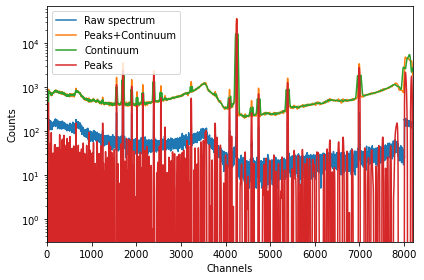

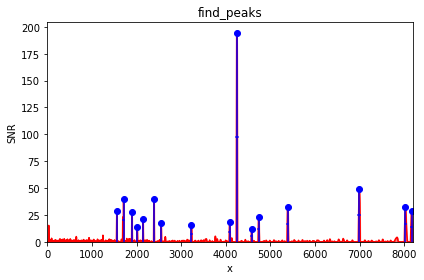

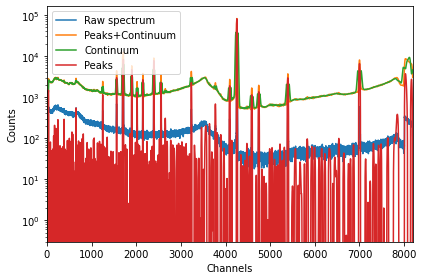

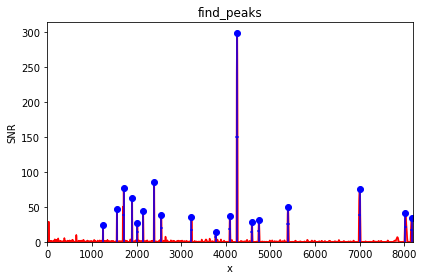

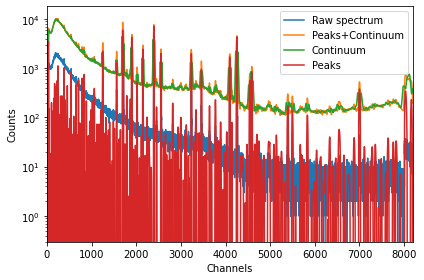

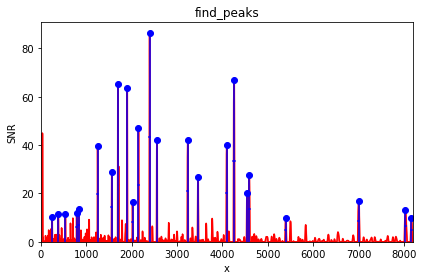

In [14]:
energies = []
for i in range(len(cal_specs)):
    energies.append(am.get_energies(cal_specs[i])) #peak finding method, bq.peakfinder


In [18]:
energies

[array([ 508,  556,  616,  653,  695,  773,  824, 1039, 1311, 1362, 1468,
        1518, 1724, 2234]),
 array([ 409,  508,  557,  616,  654,  695,  773,  824, 1040, 1211, 1312,
        1364, 1470, 1519, 1726, 2236]),
 array([  91,  135,  184,  263,  277,  410,  508,  551,  616,  654,  695,
         774,  825, 1040, 1112, 1313, 1364, 1455, 1471, 1726, 2236])]

In [23]:
iso_dfs =[]
#isotope analyzer improvement
for e in energies:
    iso_dfs.append(get_isotopes(e))

Backround isotopes [[], [], [], [], [], ['AC228'], [], [], [], [], [], [], [], []]
Possible isotopes [['CU64', 'ZN65', 'ZN71', 'ZN71', 'KR79', 'SR85', 'ZR97', 'TE121', 'PA232'], ['GE77', 'AS76', 'AS76', 'BR82', 'CD117', 'IN114', 'SB122', 'CS134', 'OS193', 'PA232'], ['ZN71', 'ZN71', 'BR82', 'AG108', 'AG110', 'BA131', 'W187', 'W187'], ['AS76', 'RU105', 'AG110', 'ND149'], ['BR82', 'ZR97', 'NB94', 'TE129'], ['ZN71', 'ZN71', 'GE77', 'BR82', 'MO99', 'TE131', 'TE131', 'EU152', 'HO166', 'W187'], [], ['BR82', 'SB124', 'BA131'], ['BR82', 'TB160'], [], [], [], [], []]
Possible isotope br [[35.2+/-0.4, 2.842+/-0.014, 28.7+/-1.4, 28.7+/-1.4, 14.0+/-0.6, 96.0, 5.03+/-0.19, 17.7+/-0.5, 5.42+/-0.14], [16.8+/-1.0, 45.0, 1.2+/-0.08, 71.7+/-1.0, 14.7+/-0.8, 4.4+/-0.6, 70.67, 8.338+/-0.014, 1.308+/-0.02, 3.75+/-0.09], [55.8+/-2.2, 55.8+/-2.2, 43.7+/-0.6, 89.8+/-1.9, 2.73+/-0.08, 1.474+/-0.016, 7.57+/-0.12, 1.314+/-0.021], [6.2+/-0.4, 2.1+/-0.3, 95.61, 8.0+/-0.5], [28.4+/-0.4, 1.01+/-0.05, 99.814, 3.0+/-0.

In [24]:
iso_dfs

[           isotopes                     energies  \
 0              BR82  [556, 616, 695, 1039, 1311]   
 1              ZN71                   [508, 616]   
 2              AS76                   [556, 653]   
 3             PA232                   [508, 556]   
 4             AG110                   [616, 653]   
 5              W187                        [616]   
 6              ZR97                   [508, 695]   
 7             BA131                  [616, 1039]   
 8             OS193                        [556]   
 9              KR79                        [508]   
 10             GE77                        [556]   
 11             NB94                        [695]   
 12             CU64                        [508]   
 13            AC228                        [773]   
 14            SB122                        [556]   
 15            CS134                        [556]   
 16            AG108                        [616]   
 17             SR85                        [5

In [66]:
print(energies[0])
print(iso_dfs[0].energies)

[ 509  557  616  655  696  774  824 1040 1312 1363 1470 1519 1725 2235]
0    [616, 696, 774, 824, 1040, 1312, 1470]
1                                    [1725]
2                                     [509]
3                                    [1519]
4                                     [557]
5                                     [655]
6                                    [1363]
Name: energies, dtype: object


In [73]:
roi = ROI.ROI(cal_specs[0], bgspec, energies[0], sub_type = 0)
delta_e = 8
window = np.array([[-2, -1], [-0.5, 0.5], [1, 2]])
roi.set_sideband(delta_e,window)
roi.find_peak_energies()
target_peaks = roi.target_peaks
roi_result,roi_uncer = roi.get_counts()
#peakfit = PF.PF(spectrum,background,source_energies)
#pf_result = peakfit.get_counts()
print(target_peaks)
print('ROI result:',roi_result)
print('uncertainties:',roi_uncer)
#print('Lu_176 PF result:',pf_result)

[ 509  557  616  655  696  774  824 1040 1312 1363 1470 1519 1725 2235]
ROI result: [2166.680412371134, 4096.260309278351, 1240.729381443299, 547.4381443298969, 742.2499999999998, 2267.922680412371, 652.069587628866, 711.8067010309278, 590.2371134020616, 39455.68298969072, 257.1314432989691, 796.8376288659791, 1382.409793814433, 2950.5850515463917]
uncertainties: [64.73216030165831, 78.14405643874032, 55.55190523517381, 46.64534981961025, 50.07282068282174, 63.351559594794374, 49.09570130467573, 54.80837047593008, 37.92131027794103, 200.80992256360244, 27.81142778542514, 35.89961304101821, 44.73180387990759, 62.16683365095545]


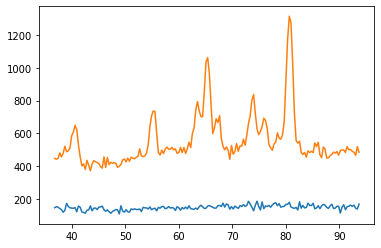

In [68]:
#spec.plot(yscale="log")
#np.where(spec.bin_centers_kev>74.9)
plt.plot(cal_specs[0].bin_centers_kev[70:250],cal_specs[0].counts_vals[70:250])
plt.plot(bgspec.bin_centers_kev[70:250],bgspec.counts_vals[70:250])

In [18]:
print(energies)#arrays for all spectra
print(energies[0])#array for a spectra in increasing energy
print(iso_dfs[0].energies) #the energies seperated per identified spectra
print(iso_dfs[0].energies[0])#the energies for one isotope in 1 spectra
print("The isotope", iso_dfs[0].isotopes[0], "has energy peaks at",iso_dfs[0].energies[0],"and br for each energy", iso_dfs[0].branching_ratios[0])

[array([ 509,  557,  616,  655,  696,  774,  824, 1040, 1312, 1363, 1470,
       1519, 1725, 2235]), array([ 409,  508,  557,  616,  654,  695,  773,  824, 1040, 1211, 1312,
       1364, 1470, 1519, 1726, 2236]), array([  91,  135,  184,  263,  277,  410,  508,  551,  616,  654,  695,
        774,  825, 1040, 1112, 1313, 1364, 1455, 1471, 1726, 2236])]
[ 509  557  616  655  696  774  824 1040 1312 1363 1470 1519 1725 2235]
0    [616, 696, 774, 824, 1040, 1312, 1470]
1                                    [1725]
2                                     [509]
3                                    [1519]
4                                     [557]
5                                     [655]
6                                    [1363]
Name: energies, dtype: object
[616, 696, 774, 824, 1040, 1312, 1470]
The isotope BR82 has energy peaks at [616, 696, 774, 824, 1040, 1312, 1470] and br for each energy [0.43700000000000006, 0.284, 0.836, 0.242, 0.276, 0.26899999999999996, 0.16390000000000002]


[ 509  557  616  655  696  774  824 1040 1312 1363 1470 1519 1725 2235]


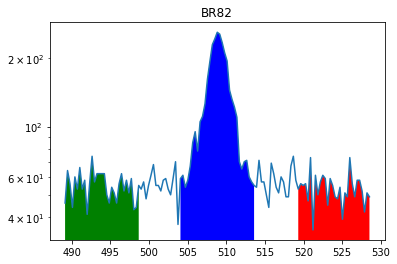

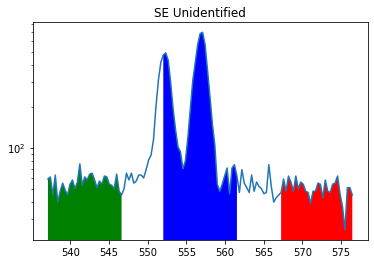

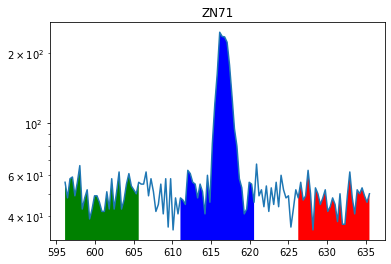

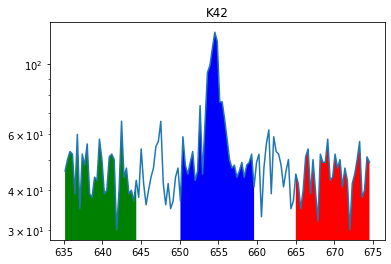

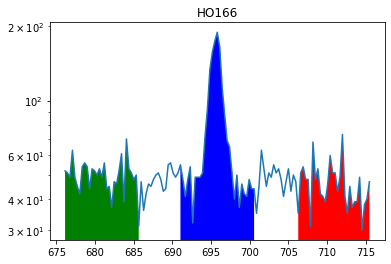

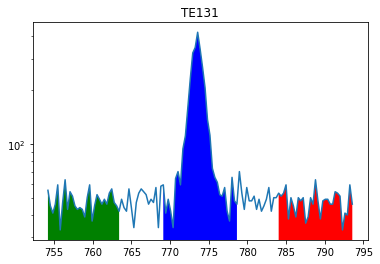

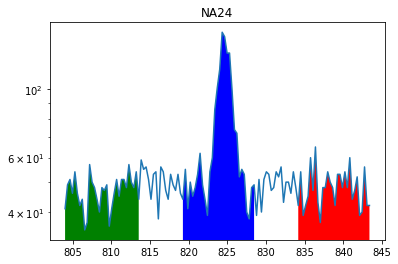

In [71]:
plot_peak_region(cal_specs[0],energies[0],iso_dfs[0].isotopes)

[ 509  557  616  655  696  774  824 1040 1312 1363 1470 1519 1725 2235]


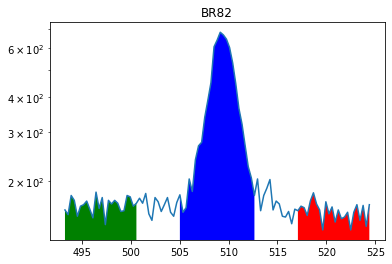

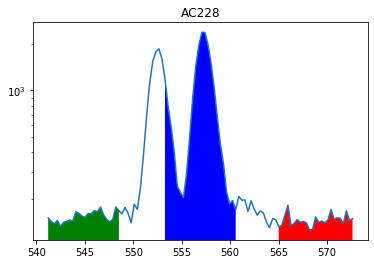

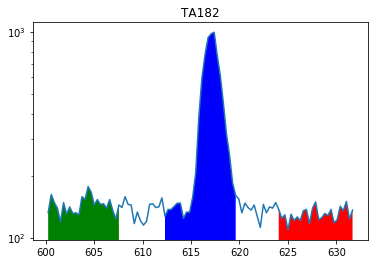

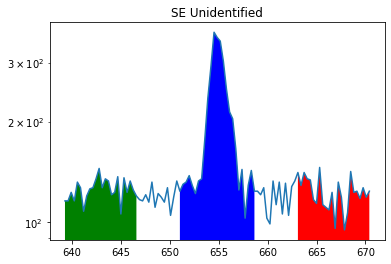

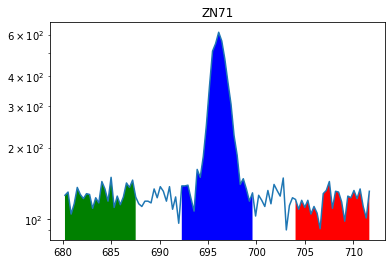

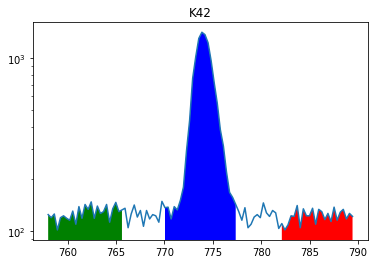

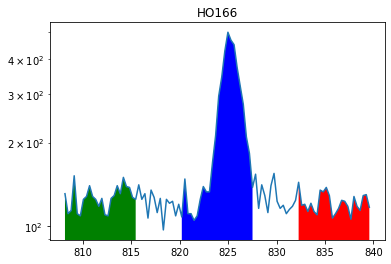

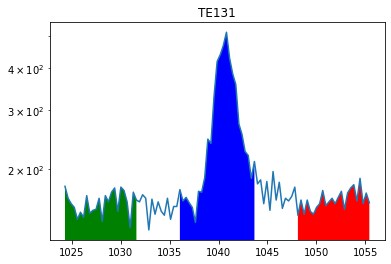

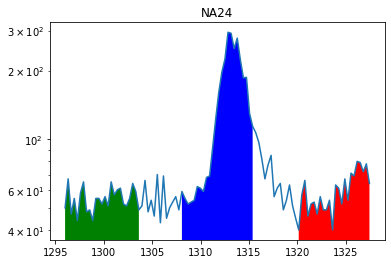

In [74]:
plot_peak_region(cal_specs[1],energies[1],iso_dfs[1].isotopes)

[ 509  557  616  655  696  774  824 1040 1312 1363 1470 1519 1725 2235]


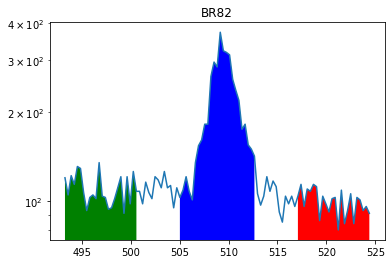

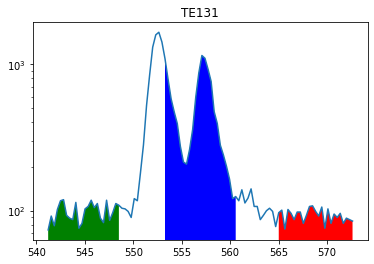

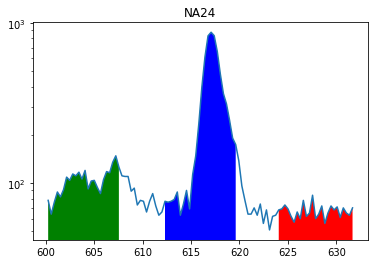

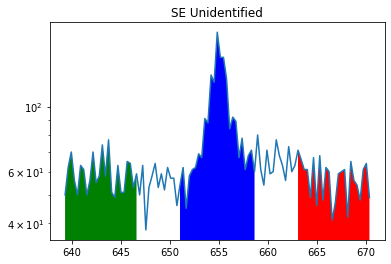

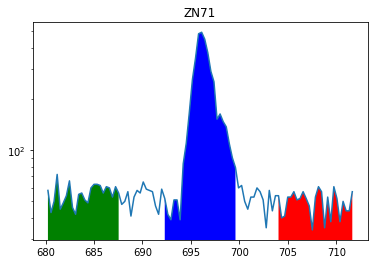

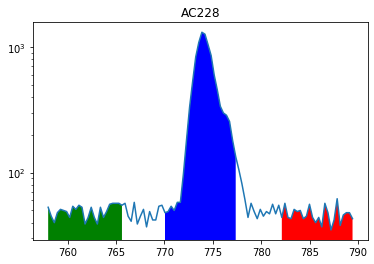

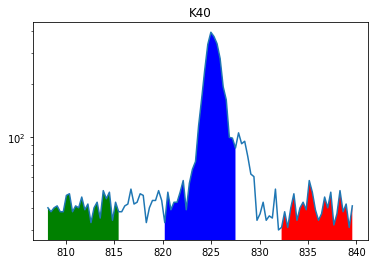

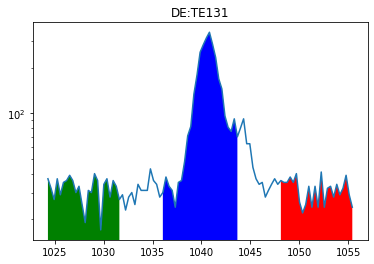

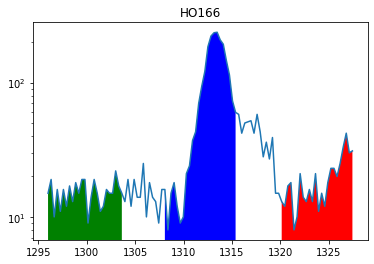

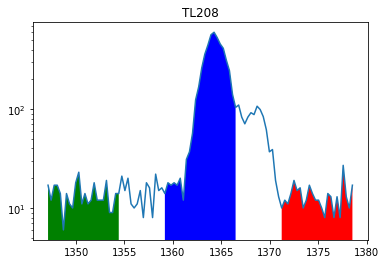

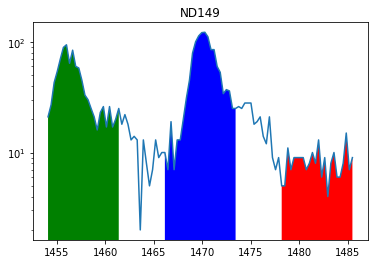

In [75]:
plot_peak_region(cal_specs[2],energies[2],iso_dfs[2].isotopes)

In [77]:
eff,eff_uncer = efficiency(roi_result,source_activities,branching_ratio,roi_uncer,activities_uncer)
print(eff,eff_uncer)
#source activities determined how? uncertainty on roi and activities?
#may have to figure out activities? Or am I doing the efficiency on the right plots?

NameError: name 'source_activities' is not defined

In [21]:
nrg_inp = np.array(iso_dfs[0].energies[0])
r,u = am.get_counts(cal_specs[0],bgspec,nrg_inp)
list1 = r/cal_specs[0].livetime
list2 =iso_dfs[0].branching_ratios[0]
products = [a * b for a, b in zip(list1, list2)]
c= np.sum(products)
brbr= iso_dfs[0].branching_ratios[0]
print(products)
print(c/np.sum(brbr))

C:\Users\Daniel\Anaconda3\lib\site-packages\becquerel-0.2.4-py3.7.egg\becquerel\core\spectrum.py:726: SpectrumWarning: Subtraction of counts-based specta, spectra have been converted to CPS
  'have been converted to CPS', SpectrumWarning)


[0.3109698601460885, 0.12991893072510483, 1.0428163171077787, 0.08742353373179895, 0.09810526378333378, 0.08670048768100956, 0.026499025672580775]
0.7107274687378663


for k in range(len(cal_specs)):
    for j in iso_dfs:
        for i in range(len(j.energies)):
            c,u = am.get_counts(cal_specs[k],bgspec,i)
            l1 = c/cal_specs[k].livetime
            l2 = j.branch

In [24]:
spectra_cnts = {"Spectrum 1 Counts":s1cnts,"Spectrum 2 Counts":s2cnts,"Spectrum 3 Counts":s3cnts}
spectra_cnts = pd.DataFrame(spectra_cnts)
spectra_cnts 

NameError: name 's1cnts' is not defined

In [ ]:
Abr = []
ibrs = []
iAs = []
mbrs =[]
for i in iso_dfs:
    for j in range(len(i.energies)):
        for k in range(len(i.energies[j])):
            ibrs = np.sum(i.branching_ratios[j][k])
            iAs = i.energies[j][k] # want counts/livetime not energies
            mbrs = i.branching_ratios[j][k]
            
print(ibrs)
#print(iAs)

In [ ]:
iso_array = []
for i in iso_dfs:
    for j in i.isotopes:
        if j in iso_array:
           continue 
        else: 
            iso_array.append(j)

In [ ]:
nrg_array = [] #keep energies with isotope? maybe this is where I find the total cps of the isotope and put it in
for i in iso_dfs:
    for j in i.energies:
        if j in nrg_array:
           continue 
        else: 
            nrg_array.append(j)

In [ ]:
iso_npt = {'isotopes':iso_array}#,"energies":nrg_array}   

isotopes = pd.DataFrame(iso_npt)
isotopes

#keep counts associated with isotopes, not just raw energy input
#reimplementing
cnts = []
uncs = []
icnts = []
iuncs = []
spcnt = []
spunc = []
for i in range(len(cal_specs)):
    for j in range(len(iso_dfs[i].energies)):
        icnts, iuncs = am.get_counts(cal_specs[i],bgspec,iso_dfs[i].energies[j])
        spcnt.append(icnts) #how to split arrays for each isotope's energies and keep with each relevant spectra
        spunc.append(iuncs)
        c.append(spcnt)
        u.append(spunc)
        spcnt = []
        spunc = []
    

In [ ]:
print(cnts)
#print(cnts[0])#counts for one iso
#find a way to order them by spectra at least

In [ ]:
#counts = []
#uncertainties =[]
#icounts = []
#iuncertainties = []
#uses PF.PF 
#for i in range(len(cal_specs)):
    icounts, iuncertainties = am.get_counts(cal_specs[i],bgspec,energies[i])
    counts.append(icounts)
    uncertainties.append(iuncertainties)

In [ ]:
print(counts)

In [ ]:
print(cal_specs[0].livetime)

In [ ]:
cps=[]
uncs =[]
for i in range(len(cal_specs)):
    cps.append(counts[i]/cal_specs[i].livetime)
    uncs.append(uncertainties[i]/cal_specs[i].livetime)

In [ ]:
print((cps))

In [ ]:
ϵ = .005
br = 1
A=[]
unc = []
for i in range(len(counts)):
    A.append(am.iso_activity(cps[i],br,ϵ))
    unc.append(am.iso_activity(uncs[i],br,ϵ))

In [ ]:
len(A)

In [ ]:
for i in range(len(A)):
    for j in range(len(A[i])):
        A[i][j] = int(A[i][j])

In [ ]:
print(A)

In [ ]:
t0 = cal_specs[0].start_time.timestamp() - (4*24*60*60) #time of irrad
print(t0)

In [ ]:
dts=[] #time of measure since time of irradiation

for i in range(len(cal_specs)):
    dts.append(am.get_dt(cal_specs[i],t0))
print(dts)

In [ ]:
iso_dfs[0]
#index through the dataframe, get info on each iso
#plug in relevant info to the eq. for each iso
#be able to select iso of interest?
#output all recognized isotopes per sample per measurement?

In [ ]:
flux = 2*10**11 #from davis trigger reactor
Tirrad = 1 *3600 #sec irradiated

#nndc scraping for verified isotope list and 
#get hl,M_A, xs, iso abundance, then list

hl_na24 = 14.9 *3600 #sec
xs_na24 = 0.531399 * (1*10**-24)
M_A = 22.989769 #g/mol
sample_wt = 1 #g
iso_abundance =1 #100% na23